In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import kagglehub
import os
import tarfile
from collections import OrderedDict
import pandas as pd
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from tqdm import tqdm # For progress bars

# Scikit-learn (for evaluation)
from sklearn.metrics import accuracy_score, top_k_accuracy_score, confusion_matrix

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# Set CUDA to run synchronously for better error messages
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Libraries imported successfully!
PyTorch version: 2.8.0+cu126
CUDA available: True


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# --- 1. Define Paths ---
DATASET_PATH = "/content/drive/MyDrive/COS30082AML/dataset/" # We are in the 'aml-project' directory
TRAIN_LIST_FILE = os.path.join(DATASET_PATH, "list/train.txt")
TEST_LIST_FILE = os.path.join(DATASET_PATH, "list/test.txt")
TEST_TRUTH_FILE = os.path.join(DATASET_PATH, "list/groundtruth.txt")
WITH_PAIRS_FILE = os.path.join(DATASET_PATH, "list/class_with_pairs.txt")
WITHOUT_PAIRS_FILE = os.path.join(DATASET_PATH, "list/class_without_pairs.txt")
TRAIN_IMG_DIR = DATASET_PATH
TEST_IMG_DIR = DATASET_PATH

# Path to save our best model
BEST_MODEL_PATH = "/content/drive/MyDrive/COS30082AML/dataset/best_finetuned_model.pth"

# --- 2. Define Hyperparameters ---
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_EPOCHS = 15       # Start with 20, you can increase this
BATCH_SIZE = 32        # Adjust based on your GPU memory
LEARNING_RATE = 0.001
NUM_CLASSES = 100
VAL_SPLIT = 0.2          # Use 20% of training data for validation

print(f"Using device: {DEVICE}")

Using device: cuda


In [ ]:
print("Building label map...")
# Load all labels from both training and test ground truth
train_labels_df = pd.read_csv(TRAIN_LIST_FILE, sep=' ', header=None)[1]
test_labels_df = pd.read_csv(TEST_TRUTH_FILE, sep=' ', header=None)[1]

# Combine them and get all unique, sorted species IDs
all_unique_species_ids = sorted(pd.concat([train_labels_df, test_labels_df]).unique())

# Create the map: {species_id: index_from_0_to_99, ...}
label_map = {species_id: i for i, species_id in enumerate(all_unique_species_ids)}
num_mapped_classes = len(label_map)

print(f"Label map created. Total unique classes found: {num_mapped_classes}")
print(f"Example mapping: ID {all_unique_species_ids[0]} -> Index {label_map[all_unique_species_ids[0]]}")

Building label map...
Label map created. Total unique classes found: 100
Example mapping: ID 12254 -> Index 0


In [ ]:
# --- 1. Define Augmentations ---

# Heavy augmentation for HERBARIUM images (the "source" domain)
train_herbarium_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    # transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2), # Stronger
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(45), # Stronger
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Light augmentation for PHOTO images (the "target" domain)
train_photo_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# NO augmentation for Validation or Test data
val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# --- 2. Modify PlantDataset ---
# Applies the correct transform based on the image path
class PlantDataset(Dataset):
    def __init__(self, txt_file, img_dir, label_map,
                 herbarium_transform=None, photo_transform=None,
                 default_transform=None, is_test=False):
        self.is_test = is_test
        self.img_data = pd.read_csv(txt_file, sep=' ', header=None)
        self.img_dir = img_dir
        self.label_map = label_map
        self.herbarium_transform = herbarium_transform
        self.photo_transform = photo_transform
        self.default_transform = default_transform

    def __len__(self):
        return len(self.img_data)

    def __getitem__(self, idx):
        img_name = self.img_data.iloc[idx, 0]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        transform = self.default_transform
        if self.herbarium_transform and 'herbarium/' in img_name:
            transform = self.herbarium_transform
        elif self.photo_transform and 'photo/' in img_name:
            transform = self.photo_transform

        if transform:
            image = transform(image)

        if self.is_test:
            return image
        else:
            species_id = int(self.img_data.iloc[idx, 1])
            label = self.label_map[species_id]
            return image, label

print("Dataset class and transforms defined.")

Dataset class and transforms defined.


In [ ]:
# --- 1. Create Datasets and Split ---
train_dataset = PlantDataset(txt_file=TRAIN_LIST_FILE,
                                  img_dir=TRAIN_IMG_DIR,
                                  label_map=label_map,
                                  herbarium_transform=train_herbarium_transform,
                                  photo_transform=train_photo_transform)

val_dataset = PlantDataset(txt_file=TEST_TRUTH_FILE,
                                     img_dir=TEST_IMG_DIR,
                                     label_map=label_map,
                                     default_transform=val_test_transform)

# val_size = int(len(full_train_dataset) * VAL_SPLIT)
# train_size = len(full_train_dataset) - val_size
# train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
# val_dataset.dataset = val_dataset_for_split # Ensures validation uses no augmentations

test_dataset = PlantDataset(txt_file=TEST_LIST_FILE,
                            img_dir=TEST_IMG_DIR,
                            label_map=label_map,
                            default_transform=val_test_transform,
                            is_test=True)

print(f"Split into: {len(train_dataset)} training, {len(val_dataset)} validation")
print(f"Test data: {len(test_dataset)} samples")

# --- 2. Handle Class Imbalance ---
print("\nCalculating class weights for imbalance...")
all_train_labels = pd.read_csv(TRAIN_LIST_FILE, sep=' ', header=None)[1].map(label_map)
class_counts_series = all_train_labels.value_counts()

full_class_index = np.arange(NUM_CLASSES)
class_counts = class_counts_series.reindex(full_class_index, fill_value=0).sort_index()
counts_plus_one = torch.tensor(class_counts.values, dtype=torch.float) + 1.0 # Add 1 to avoid / 0
class_weights = 1.0 / counts_plus_one
class_weights = class_weights / class_weights.sum() * NUM_CLASSES # Normalize
class_weights = class_weights.to(DEVICE)
print(f"Class weights tensor created with {len(class_weights)} entries.")



Split into: 4744 training, 207 validation
Test data: 207 samples

Calculating class weights for imbalance...
Class weights tensor created with 100 entries.


In [ ]:
import random
from torch.utils.data import Dataset

class TripletDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

        # Get all labels directly
        self.labels = [int(label) for _, label in dataset]

        # Group sample indices by label
        self.label_to_indices = {}
        for idx, label in enumerate(self.labels):
            self.label_to_indices.setdefault(label, []).append(idx)
         # Keep only indices with at least 2 samples in their class
        self.valid_indices = [i for i, label in enumerate(self.labels) if len(self.label_to_indices[label]) > 1]

    def __getitem__(self, index):
        anchor_img, anchor_label = self.dataset[index]
        anchor_label = int(anchor_label)

        # --- Positive (same class) ---
        positive_index = index
        while positive_index == index:
            positive_index = random.choice(self.label_to_indices[anchor_label])
        positive_img, _ = self.dataset[positive_index]

        # --- Negative (different class) ---
        all_labels = list(self.label_to_indices.keys())
        different_labels = [l for l in all_labels if l != anchor_label]
        negative_label = random.choice(different_labels)
        negative_index = random.choice(self.label_to_indices[negative_label])
        negative_img, _ = self.dataset[negative_index]

        return anchor_img, positive_img, negative_img, anchor_label

    def __len__(self):
        return len(self.dataset)


In [ ]:
triplet_train_dataset = TripletDataset(train_dataset)
triplet_val_dataset = TripletDataset(val_dataset)

/tmp/ipython-input-1120987600.py:45: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1120987600.py:45: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


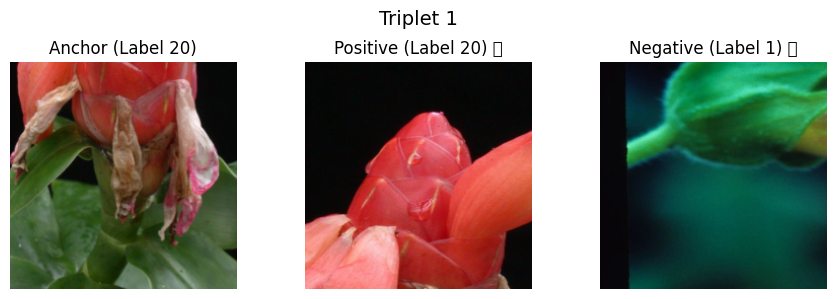

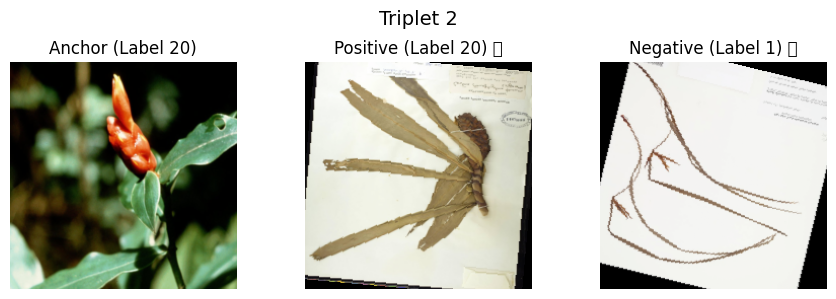

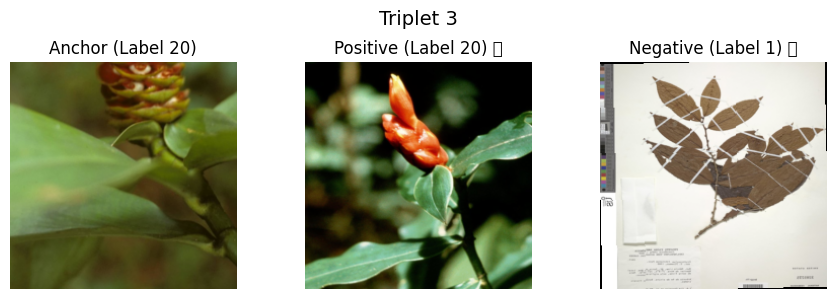

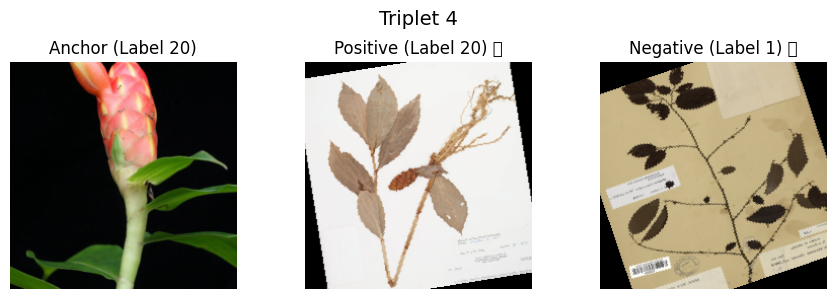

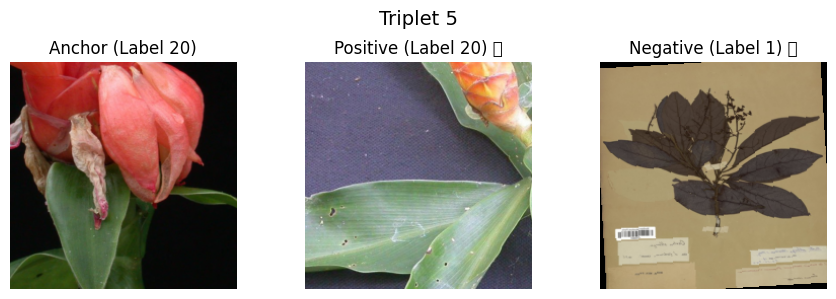

In [ ]:
import matplotlib.pyplot as plt
import torch

# Undo normalization for visualization
def denormalize(img_tensor):
    if not torch.is_tensor(img_tensor):
        return img_tensor
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img_tensor * std + mean
    return img.clamp(0, 1)

# Show first 5 triplets with labels
for i in range(5):
    anchor_img, positive_img, negative_img, anchor_label = triplet_train_dataset[i]

    # get their real labels
    pos_label = anchor_label  # positive is same as anchor
    # get one sample index from another class for negative
    negative_label = None
    for lbl, idxs in triplet_train_dataset.label_to_indices.items():
        if lbl != anchor_label:
            negative_label = lbl
            break

    # Prepare denormalized images
    imgs = [anchor_img, positive_img, negative_img]
    imgs = [denormalize(img).permute(1, 2, 0).numpy() for img in imgs]

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(9, 3))
    fig.suptitle(f"Triplet {i+1}", fontsize=14)

    titles = [
        f"Anchor (Label {anchor_label})",
        f"Positive (Label {pos_label}) ✅",
        f"Negative (Label {negative_label}) ❌"
    ]

    for ax, img, title in zip(axes, imgs, titles):
        ax.imshow(img)
        ax.set_title(title)
        ax.axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:
# --- 3. Create DataLoaders ---
train_loader = DataLoader(triplet_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(triplet_val_dataset, batch_size=BATCH_SIZE, shuffle=False,num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,num_workers=2)
print(f"DataLoaders created.")

# --- 4. Load and map ground truth test labels ---
original_test_labels = pd.read_csv(TEST_TRUTH_FILE, sep=' ', header=None).iloc[:, 1].values
y_test = np.array([label_map[label] for label in original_test_labels])
print(f"y_test (ground truth) labels loaded and mapped to [0-99].")

DataLoaders created.
y_test (ground truth) labels loaded and mapped to [0-99].


In [ ]:
import argparse
import torch.nn.functional as F

print("Downloading model files...")
model_dir = kagglehub.model_download("juliostat/dinov2_patch14_reg4_onlyclassifier_then_all/pyTorch/default")
WEIGHTS_FILE = os.path.join(model_dir, 'model_best.pth.tar')
print(f"Weights file path: {WEIGHTS_FILE}")

# --- 1. Load the CORRECT Model Architecture ---
print("Loading DINOv2 ViT-Base (vitb14_reg) architecture...")
model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14_reg', trust_repo=True)
print("Architecture loaded.")

# --- 2. Load Your Downloaded Kaggle Checkpoint ---
print(f"Loading weights from checkpoint: {WEIGHTS_FILE}")
torch.serialization.add_safe_globals([argparse.Namespace]) # Allow loading 'argparse'
checkpoint = torch.load(WEIGHTS_FILE, map_location='cpu', weights_only=True)

# --- 3. Extract and Clean the 'state_dict' ---
if 'state_dict' in checkpoint:
    state_dict = checkpoint['state_dict']
    print("Found 'state_dict' key in checkpoint.")
else:
    raise KeyError("Checkpoint does not contain 'state_dict' key.")

print("Cleaning checkpoint state_dict...")
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k.replace('module.', '')
    if name == 'reg_token': name = 'register_tokens'
    if 'head.' in name: continue # Skip old head
    if name == 'pos_embed':
        model_pos_embed = model.state_dict()['pos_embed']
        if v.shape != model_pos_embed.shape:
            zeros_to_add = torch.zeros(1, 1, v.shape[2])
            v = torch.cat((v, zeros_to_add), dim=1)
    new_state_dict[name] = v

# --- 4. Load Cleaned Weights into Model ---
model.load_state_dict(new_state_dict, strict=False) # strict=False ignores the missing 'mask_token'
print("Successfully loaded Kaggle weights into model architecture.")

# --- 5. Freeze the Backbone ---
print("Freezing backbone parameters...")
for param in model.parameters():
    param.requires_grad = False
# unfreeze two block
for block in model.blocks[-2:]:  # blocks 10 and 11
    for param in block.parameters():
        param.requires_grad = True


# --- 7. Move to GPU ---
model = model.to(DEVICE)
print(f"Model moved to {DEVICE}.")

Weights file path: /kaggle/input/dinov2_patch14_reg4_onlyclassifier_then_all/pytorch/default/3/model_best.pth.tar
Loading DINOv2 ViT-Base (vitb14_reg) architecture...
Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip


/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitb14/dinov2_vitb14_reg4_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vitb14_reg4_pretrain.pth


100%|██████████| 330M/330M [00:00<00:00, 416MB/s]


Architecture loaded.
Loading weights from checkpoint: /kaggle/input/dinov2_patch14_reg4_onlyclassifier_then_all/pytorch/default/3/model_best.pth.tar
Found 'state_dict' key in checkpoint.
Cleaning checkpoint state_dict...
Successfully loaded Kaggle weights into model architecture.
Freezing backbone parameters...
Model moved to cuda.


In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
# change 1.0 to 0.5
triplet_loss_fn = nn.TripletMarginLoss(margin=0.5, p=2)
MARGIN = 0.5
# lower the learning rate to 0.0001
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

# --- 2. Training Loop ---
best_val_loss = float('inf')
history_train_loss = []
history_val_loss = []
history_train_acc = []
history_val_acc = []

def compute_triplet_accuracy(a, p, n, margin):
    d_ap = F.pairwise_distance(a, p)
    d_an = F.pairwise_distance(a, n)
    correct = (d_ap + margin < d_an).float()
    return correct.mean().item()

for epoch in range(NUM_EPOCHS):
    print(f"\n--- Epoch {epoch+1}/{NUM_EPOCHS} ---")

    # --- Training Phase ---
    model.train()
    running_train_loss = 0.0
    running_train_acc = 0.0
    total_train_batches = 0

    for anchor, positive, negative, _ in tqdm(train_loader, desc="Training"):
        anchor, positive, negative = anchor.to(DEVICE), positive.to(DEVICE), negative.to(DEVICE)

        emb_anchor = model(anchor)
        emb_positive = model(positive)
        emb_negative = model(negative)

        loss = triplet_loss_fn(emb_anchor, emb_positive, emb_negative)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * anchor.size(0)

        # --- Triplet Accuracy ---
        batch_acc = compute_triplet_accuracy(emb_anchor, emb_positive, emb_negative, MARGIN)
        running_train_acc += batch_acc
        total_train_batches += 1

    epoch_train_loss = running_train_loss / len(train_dataset)
    epoch_train_acc = running_train_acc / total_train_batches

    print(f"Training Loss: {epoch_train_loss:.4f} | Triplet Acc: {epoch_train_acc:.4f}")

    # # --- Validation Phase ---
    # model.eval()
    # running_val_loss = 0.0
    # running_val_acc = 0.0
    # total_val_batches = 0

    # with torch.no_grad():
    #     for anchor, positive, negative, _ in tqdm(val_loader, desc="Validating"):
    #         anchor, positive, negative = anchor.to(DEVICE), positive.to(DEVICE), negative.to(DEVICE)

    #         emb_anchor = model(anchor)
    #         emb_positive = model(positive)
    #         emb_negative = model(negative)

    #         loss = triplet_loss_fn(emb_anchor, emb_positive, emb_negative)
    #         running_val_loss += loss.item() * anchor.size(0)

    #         # --- Triplet Accuracy ---
    #         batch_acc = compute_triplet_accuracy(emb_anchor, emb_positive, emb_negative, MARGIN)
    #         running_val_acc += batch_acc
    #         total_val_batches += 1

    # epoch_val_loss = running_val_loss / len(val_dataset)
    # epoch_val_acc = running_val_acc / total_val_batches

    # print(f"Validation Loss: {epoch_val_loss:.4f} | Triplet Acc: {epoch_val_acc:.4f}")

    history_train_loss.append(epoch_train_loss)
    # history_val_loss.append(epoch_val_loss)
    history_train_acc.append(epoch_train_acc)
    # history_val_acc.append(epoch_val_acc)


print("\n--- Training Complete ---")



--- Epoch 1/15 ---


Training: 100%|██████████| 149/149 [04:36<00:00,  1.85s/it]


Training Loss: 0.1548 | Triplet Acc: 0.7460

--- Epoch 2/15 ---


Training: 100%|██████████| 149/149 [04:34<00:00,  1.84s/it]


Training Loss: 0.1347 | Triplet Acc: 0.7473

--- Epoch 3/15 ---


Training: 100%|██████████| 149/149 [04:34<00:00,  1.84s/it]


Training Loss: 0.1164 | Triplet Acc: 0.7819

--- Epoch 4/15 ---


Training: 100%|██████████| 149/149 [04:35<00:00,  1.85s/it]


Training Loss: 0.1071 | Triplet Acc: 0.7964

--- Epoch 5/15 ---


Training: 100%|██████████| 149/149 [04:34<00:00,  1.84s/it]


Training Loss: 0.0917 | Triplet Acc: 0.8194

--- Epoch 6/15 ---


Training: 100%|██████████| 149/149 [04:34<00:00,  1.84s/it]


Training Loss: 0.0891 | Triplet Acc: 0.8247

--- Epoch 7/15 ---


Training: 100%|██████████| 149/149 [04:33<00:00,  1.84s/it]


Training Loss: 0.0826 | Triplet Acc: 0.8406

--- Epoch 8/15 ---


Training: 100%|██████████| 149/149 [04:32<00:00,  1.83s/it]


Training Loss: 0.0847 | Triplet Acc: 0.8368

--- Epoch 9/15 ---


Training: 100%|██████████| 149/149 [04:39<00:00,  1.88s/it]


Training Loss: 0.0889 | Triplet Acc: 0.8284

--- Epoch 10/15 ---


Training: 100%|██████████| 149/149 [04:35<00:00,  1.85s/it]


Training Loss: 0.0741 | Triplet Acc: 0.8513

--- Epoch 11/15 ---


Training: 100%|██████████| 149/149 [04:36<00:00,  1.86s/it]


Training Loss: 0.0675 | Triplet Acc: 0.8658

--- Epoch 12/15 ---


Training: 100%|██████████| 149/149 [04:35<00:00,  1.85s/it]


Training Loss: 0.0681 | Triplet Acc: 0.8674

--- Epoch 13/15 ---


Training: 100%|██████████| 149/149 [04:37<00:00,  1.86s/it]


Training Loss: 0.0623 | Triplet Acc: 0.8779

--- Epoch 14/15 ---


Training: 100%|██████████| 149/149 [04:36<00:00,  1.85s/it]


Training Loss: 0.0589 | Triplet Acc: 0.8809

--- Epoch 15/15 ---


Training: 100%|██████████| 149/149 [04:36<00:00,  1.85s/it]

Training Loss: 0.0579 | Triplet Acc: 0.8857

--- Training Complete ---


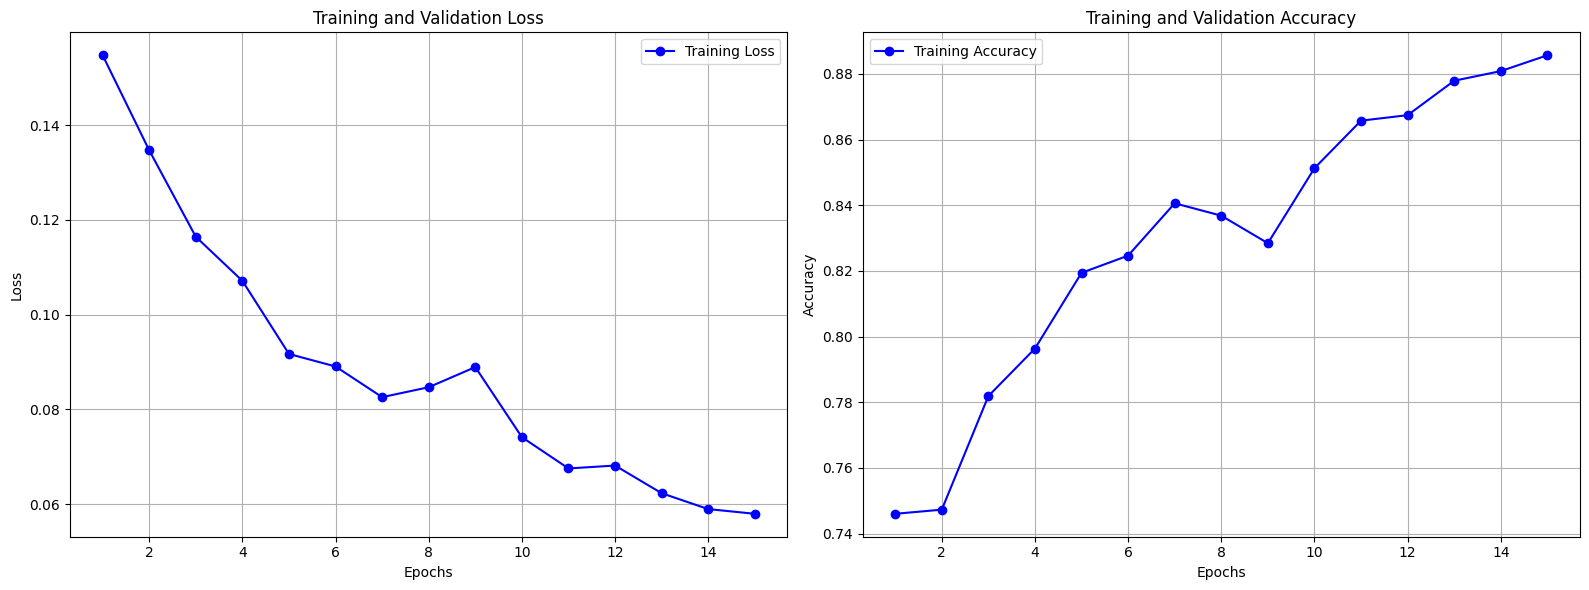

In [ ]:
epochs = range(1, len(history_train_loss) + 1)

plt.figure(figsize=(16, 6))

# Plot 1: Training & Validation Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, history_train_loss, 'b-o', label='Training Loss')
# plt.plot(epochs, history_val_loss, 'r-o', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Training & Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history_train_acc, 'b-o', label='Training Accuracy')
# plt.plot(epochs, history_val_acc, 'r-o', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
#Stage 2 training
# Reload the best stage 1 model
# model.load_state_dict(torch.load(BEST_MODEL_PATH))
# model.to(DEVICE)

# --- 5. Freeze the Backbone ---
print("Freezing backbone parameters...")
for param in model.parameters():
    param.requires_grad = False

class PlantClassifier(nn.Module):
    def __init__(self, feature_dim=768, num_classes=100):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.LayerNorm(feature_dim),         # Helps stabilize distribution
            nn.Linear(feature_dim, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        return self.classifier(x)
model.head = PlantClassifier().to(DEVICE)



Freezing backbone parameters...


In [ ]:
stage2_train_dataset = PlantDataset(txt_file=TRAIN_LIST_FILE,
                                  img_dir=TRAIN_IMG_DIR,
                                  label_map=label_map,
                                  herbarium_transform=train_herbarium_transform,
                                  photo_transform=train_photo_transform)
stage2_val_dataset = PlantDataset(txt_file=TEST_TRUTH_FILE,
                                     img_dir=TEST_IMG_DIR,
                                     label_map=label_map,
                                     default_transform=val_test_transform)

stage2_train_loader = DataLoader(stage2_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
stage2_val_loader = DataLoader(stage2_val_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [ ]:
# --- 1. Define Loss Function and Optimizer ---
loss_fn = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.head.parameters(), lr=LEARNING_RATE) # Only train the new head

# --- 2. Training Loop ---
best_val_acc = 0.0
history_train_loss = []
history_train_acc = []
history_val_loss = []
history_val_acc = []

for epoch in range(NUM_EPOCHS):
    print(f"\n--- Epoch {epoch+1}/{NUM_EPOCHS} ---")

    # --- Training Phase ---
    model.train()
    train_loss = 0.0
    train_correct = 0

    for images, labels in tqdm(stage2_train_loader, desc="Training"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        outputs = model(images)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += torch.sum(preds == labels.data)

    train_acc = train_correct.double() / len(stage2_train_dataset)
    train_loss = train_loss / len(stage2_train_dataset)
    print(f"Training Loss: {train_loss:.4f} | Training Acc: {train_acc*100:.2f}%")

    # --- Validation Phase ---
    model.eval()
    val_loss = 0.0
    val_correct = 0

    with torch.no_grad():
        for images, labels in tqdm(stage2_val_loader, desc="Validating"):
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            outputs = model(images)
            loss = loss_fn(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += torch.sum(preds == labels.data)

    val_acc = val_correct.double() / len(stage2_val_dataset)
    val_loss = val_loss / len(stage2_val_dataset)
    print(f"Validation Loss: {val_loss:.4f} | Validation Acc: {val_acc*100:.2f}%")

    # Store history for plotting
    history_train_loss.append(train_loss)
    history_train_acc.append(train_acc.cpu())
    history_val_loss.append(val_loss)
    history_val_acc.append(val_acc.cpu())

    # --- Save the Best Model ---
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print(f"*** New best model saved! Accuracy: {best_val_acc*100:.2f}% ***")

print("\n--- Training Complete ---")


--- Epoch 1/15 ---


Training: 100%|██████████| 149/149 [02:13<00:00,  1.12it/s]


Training Loss: 3.9295 | Training Acc: 14.17%


Validating: 100%|██████████| 7/7 [00:06<00:00,  1.02it/s]


Validation Loss: 3.1780 | Validation Acc: 25.60%
*** New best model saved! Accuracy: 25.60% ***

--- Epoch 2/15 ---


Training: 100%|██████████| 149/149 [02:14<00:00,  1.11it/s]


Training Loss: 2.1437 | Training Acc: 44.44%


Validating: 100%|██████████| 7/7 [00:06<00:00,  1.00it/s]


Validation Loss: 2.1859 | Validation Acc: 50.24%
*** New best model saved! Accuracy: 50.24% ***

--- Epoch 3/15 ---


Training: 100%|██████████| 149/149 [02:16<00:00,  1.09it/s]


Training Loss: 1.4808 | Training Acc: 58.39%


Validating: 100%|██████████| 7/7 [00:06<00:00,  1.00it/s]


Validation Loss: 2.0290 | Validation Acc: 52.17%
*** New best model saved! Accuracy: 52.17% ***

--- Epoch 4/15 ---


Training: 100%|██████████| 149/149 [02:17<00:00,  1.09it/s]


Training Loss: 1.2409 | Training Acc: 62.92%


Validating: 100%|██████████| 7/7 [00:06<00:00,  1.00it/s]


Validation Loss: 2.0556 | Validation Acc: 53.62%
*** New best model saved! Accuracy: 53.62% ***

--- Epoch 5/15 ---


Training: 100%|██████████| 149/149 [02:16<00:00,  1.09it/s]


Training Loss: 1.1200 | Training Acc: 66.36%


Validating: 100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


Validation Loss: 2.0457 | Validation Acc: 55.56%
*** New best model saved! Accuracy: 55.56% ***

--- Epoch 6/15 ---


Training: 100%|██████████| 149/149 [02:16<00:00,  1.09it/s]


Training Loss: 1.0458 | Training Acc: 69.48%


Validating: 100%|██████████| 7/7 [00:07<00:00,  1.00s/it]


Validation Loss: 1.9917 | Validation Acc: 58.94%
*** New best model saved! Accuracy: 58.94% ***

--- Epoch 7/15 ---


Training: 100%|██████████| 149/149 [02:15<00:00,  1.10it/s]


Training Loss: 0.9731 | Training Acc: 70.85%


Validating: 100%|██████████| 7/7 [00:06<00:00,  1.02it/s]


Validation Loss: 2.1044 | Validation Acc: 58.94%

--- Epoch 8/15 ---


Training: 100%|██████████| 149/149 [02:10<00:00,  1.14it/s]


Training Loss: 0.9504 | Training Acc: 70.43%


Validating: 100%|██████████| 7/7 [00:06<00:00,  1.14it/s]


Validation Loss: 2.1355 | Validation Acc: 56.52%

--- Epoch 9/15 ---


Training: 100%|██████████| 149/149 [02:09<00:00,  1.15it/s]


Training Loss: 0.9489 | Training Acc: 70.66%


Validating: 100%|██████████| 7/7 [00:06<00:00,  1.07it/s]


Validation Loss: 2.0786 | Validation Acc: 61.35%
*** New best model saved! Accuracy: 61.35% ***

--- Epoch 10/15 ---


Training: 100%|██████████| 149/149 [02:13<00:00,  1.11it/s]


Training Loss: 0.8887 | Training Acc: 72.55%


Validating: 100%|██████████| 7/7 [00:06<00:00,  1.14it/s]


Validation Loss: 2.0785 | Validation Acc: 60.39%

--- Epoch 11/15 ---


Training: 100%|██████████| 149/149 [02:09<00:00,  1.15it/s]


Training Loss: 0.8673 | Training Acc: 73.29%


Validating: 100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


Validation Loss: 2.1259 | Validation Acc: 57.49%

--- Epoch 12/15 ---


Training: 100%|██████████| 149/149 [02:10<00:00,  1.14it/s]


Training Loss: 0.8660 | Training Acc: 73.50%


Validating: 100%|██████████| 7/7 [00:06<00:00,  1.14it/s]


Validation Loss: 2.0770 | Validation Acc: 57.97%

--- Epoch 13/15 ---


Training: 100%|██████████| 149/149 [02:09<00:00,  1.15it/s]


Training Loss: 0.8435 | Training Acc: 74.09%


Validating: 100%|██████████| 7/7 [00:06<00:00,  1.10it/s]


Validation Loss: 2.1342 | Validation Acc: 58.94%

--- Epoch 14/15 ---


Training: 100%|██████████| 149/149 [02:09<00:00,  1.15it/s]


Training Loss: 0.7981 | Training Acc: 74.66%


Validating: 100%|██████████| 7/7 [00:06<00:00,  1.03it/s]


Validation Loss: 2.1810 | Validation Acc: 59.42%

--- Epoch 15/15 ---


Training: 100%|██████████| 149/149 [02:10<00:00,  1.15it/s]


Training Loss: 0.7887 | Training Acc: 75.40%


Validating: 100%|██████████| 7/7 [00:06<00:00,  1.14it/s]

Validation Loss: 2.2824 | Validation Acc: 59.90%

--- Training Complete ---


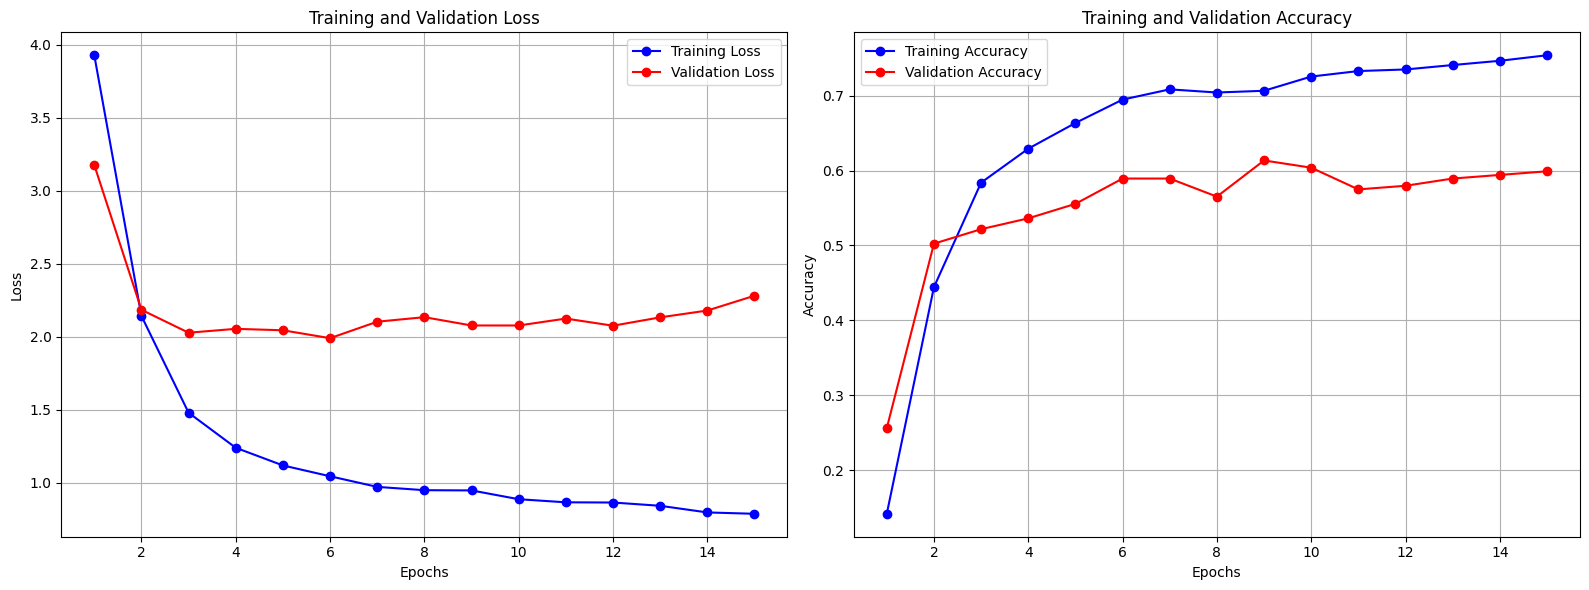

In [ ]:
epochs = range(1, len(history_train_loss) + 1)

plt.figure(figsize=(16, 6))

# Plot 1: Training & Validation Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, history_train_loss, 'b-o', label='Training Loss')
plt.plot(epochs, history_val_loss, 'r-o', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Training & Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history_train_acc, 'b-o', label='Training Accuracy')
plt.plot(epochs, history_val_acc, 'r-o', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# --- 1. Load the Best Model ---
print("Loading best fine-tuned model for evaluation...")
# Create a new instance of the model architecture
eval_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14_reg', trust_repo=True)

class PlantClassifier(nn.Module):
    def __init__(self, feature_dim=768, num_classes=100):
        super().__init__()
        self.classifier = nn.Sequential(
             nn.LayerNorm(feature_dim),         # Helps stabilize distribution
            nn.Linear(feature_dim, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        return self.classifier(x)

eval_model.head = PlantClassifier()

# Load the saved weights (state_dict)
eval_model.load_state_dict(torch.load(BEST_MODEL_PATH, weights_only=True))
eval_model = eval_model.to(DEVICE)
eval_model.eval() # Set to evaluation mode
print("Best model loaded successfully.")

# --- 2. Evaluate on Test Set ---
all_predictions = []

with torch.no_grad():
    for images in tqdm(test_loader, desc="Evaluating on Test Set"):
        images = images.to(DEVICE)
        outputs = eval_model(images)
        all_predictions.append(outputs.cpu())

# Concatenate all batch outputs into one big tensor
y_pred_probas = torch.cat(all_predictions, dim=0)
print("Evaluation complete.")

Loading best fine-tuned model for evaluation...


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


Best model loaded successfully.


Evaluating on Test Set: 100%|██████████| 7/7 [00:06<00:00,  1.14it/s]

Evaluation complete.


In [ ]:
print("Calculating metrics for New Approach...")

# --- 1. Top-1 Accuracy ---
y_pred_top1 = torch.argmax(y_pred_probas, dim=1).numpy()
top1_acc = accuracy_score(y_test, y_pred_top1)
print(f"  Top-1 Accuracy: {top1_acc * 100:.2f}%")

# --- 2. Top-5 Accuracy ---
all_class_labels = np.arange(NUM_CLASSES)
top5_acc = top_k_accuracy_score(y_test, y_pred_probas.numpy(), k=5, labels=all_class_labels)
print(f"  Top-5 Accuracy: {top5_acc * 100:.2f}%")

Calculating metrics for New Approach...
  Top-1 Accuracy: 61.35%
  Top-5 Accuracy: 81.16%


Generating confusion matrix...


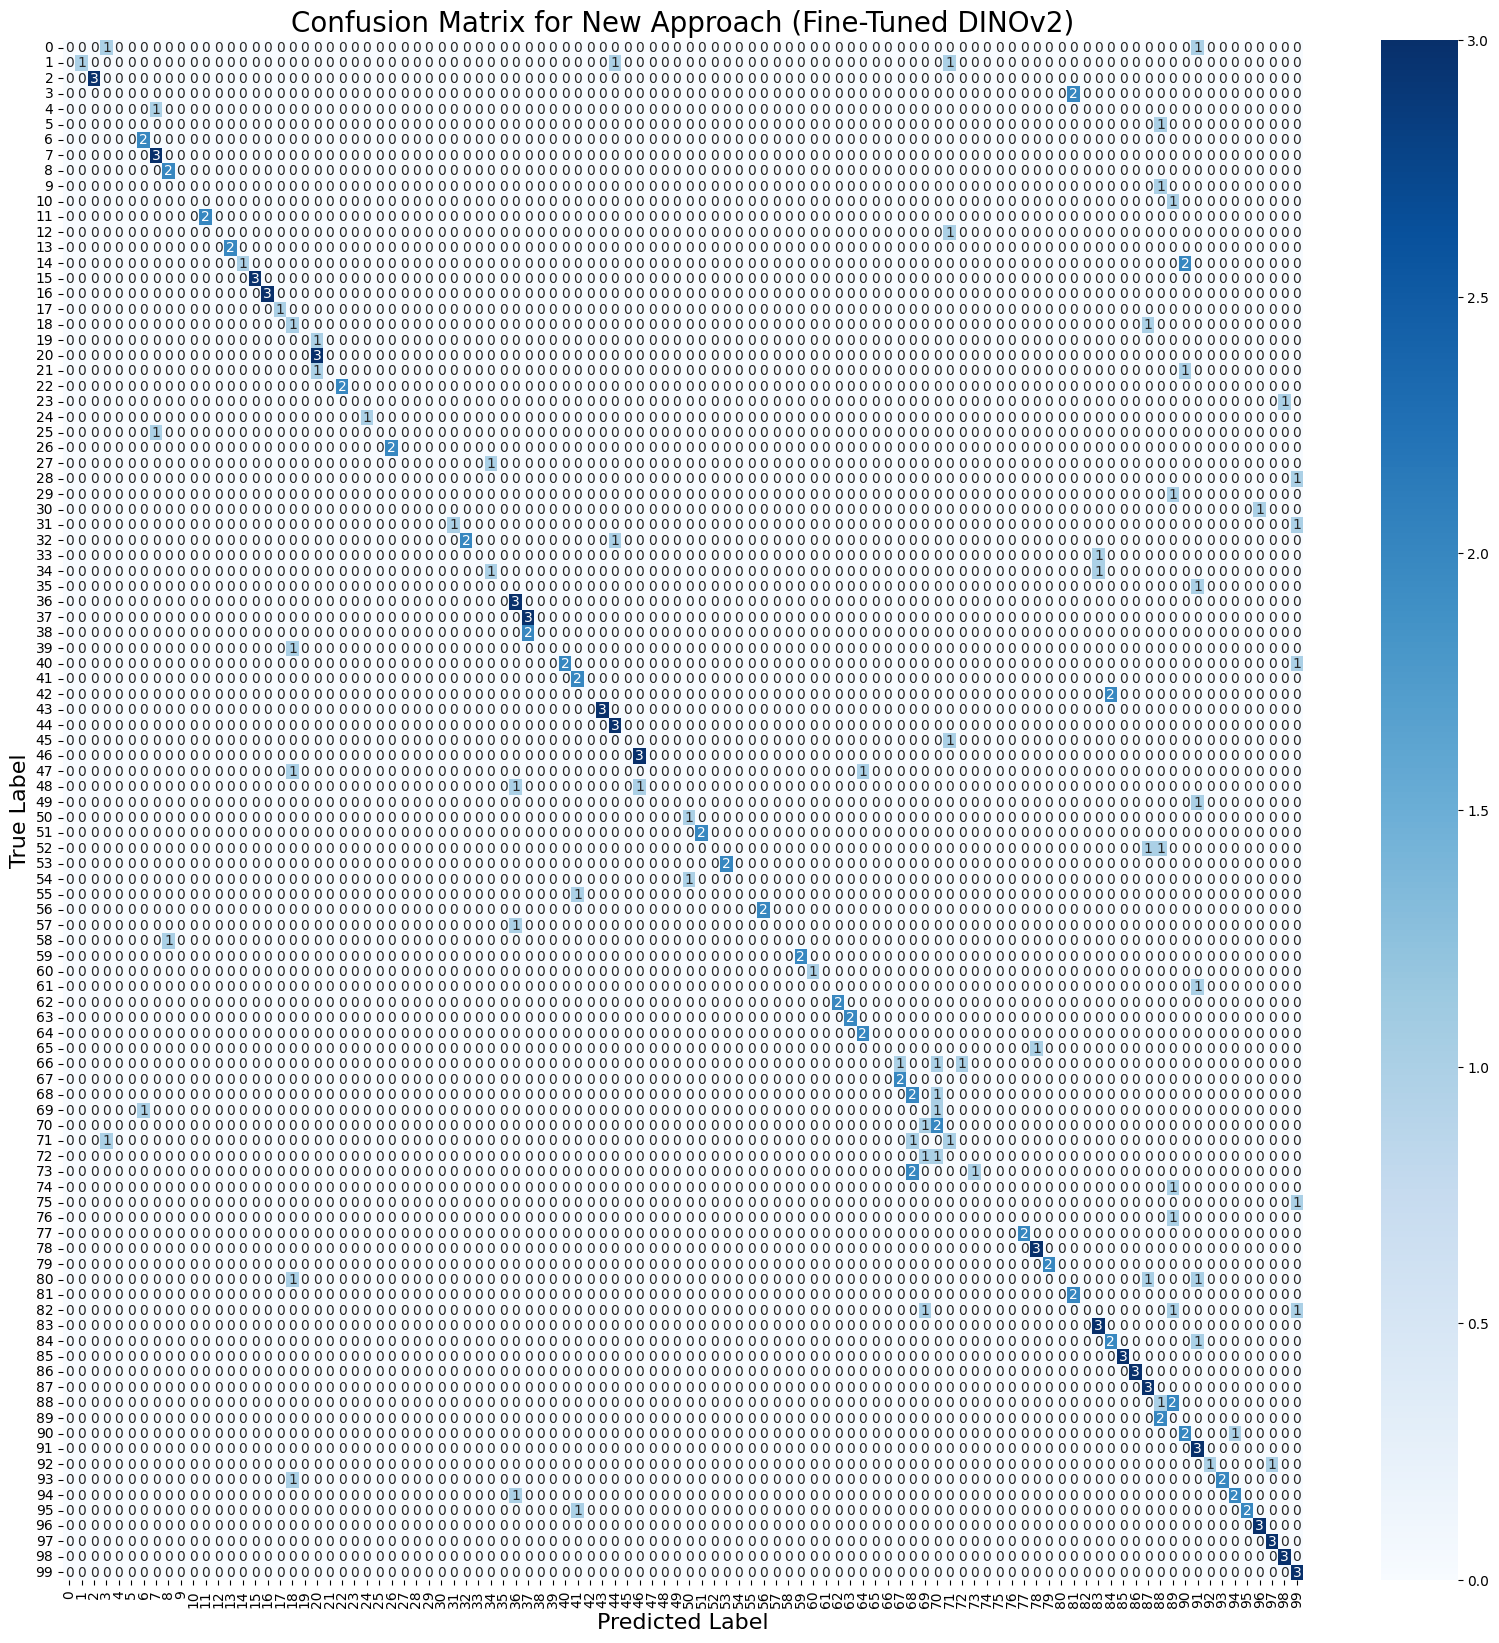

In [ ]:
print("Generating confusion matrix...")
cm = confusion_matrix(y_test, y_pred_top1)

plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=all_class_labels, yticklabels=all_class_labels)
plt.title('Confusion Matrix for New Approach (Fine-Tuned DINOv2)', fontsize=20)
plt.ylabel('True Label', fontsize=16)
plt.xlabel('Predicted Label', fontsize=16)
plt.show()

In [ ]:
print("--- Analysis of Performance by Class Type ---")

# 1. Load original Species ID lists
with_pairs_ids = set(pd.read_csv(WITH_PAIRS_FILE, header=None).iloc[:, 0])
without_pairs_ids = set(pd.read_csv(WITHOUT_PAIRS_FILE, header=None).iloc[:, 0])

# 2. Map Species IDs to our new Class Indices (0-99)
with_pairs_set = {label_map.get(id, -1) for id in with_pairs_ids}
without_pairs_set = {label_map.get(id, -1) for id in without_pairs_ids}
print(f"Loaded and mapped 'with pairs'/'without pairs' class indices.")

# 3. Filter Test Results
test_with_pairs_indices = [i for i, label in enumerate(y_test) if label in with_pairs_set]
test_without_pairs_indices = [i for i, label in enumerate(y_test) if label in without_pairs_set]
print(f"Found {len(test_with_pairs_indices)} 'with pairs' samples and {len(test_without_pairs_indices)} 'without pairs' samples.")

# 4. Create Filtered Arrays
y_test_with_pairs = y_test[test_with_pairs_indices]
y_pred_top1_with_pairs = y_pred_top1[test_with_pairs_indices]
y_probas_with_pairs = y_pred_probas[test_with_pairs_indices]

y_test_without_pairs = y_test[test_without_pairs_indices]
y_pred_top1_without_pairs = y_pred_top1[test_without_pairs_indices]
y_probas_without_pairs = y_pred_probas[test_without_pairs_indices]

# 5. Calculate Accuracy
acc_top1_with = accuracy_score(y_test_with_pairs, y_pred_top1_with_pairs)
acc_top5_with = top_k_accuracy_score(y_test_with_pairs, y_probas_with_pairs, k=5, labels=all_class_labels)

acc_top1_without = accuracy_score(y_test_without_pairs, y_pred_top1_without_pairs)
acc_top5_without = top_k_accuracy_score(y_test_without_pairs, y_probas_without_pairs, k=5, labels=all_class_labels)

# 6. Print Comparison
print(f"\nGroup: WITH PAIRS (Trained on Herbarium + Field)")
print(f"  Top-1 Accuracy: {acc_top1_with * 100:.2f}%")
print(f"  Top-5 Accuracy: {acc_top5_with * 100:.2f}%")

print(f"\nGroup: WITHOUT PAIRS (Trained on Herbarium ONLY)")
print(f"  Top-1 Accuracy: {acc_top1_without * 100:.2f}%")
print(f"  Top-5 Accuracy: {acc_top5_without * 100:.2f}%")

--- Analysis of Performance by Class Type ---
Loaded and mapped 'with pairs'/'without pairs' class indices.
Found 153 'with pairs' samples and 54 'without pairs' samples.

Group: WITH PAIRS (Trained on Herbarium + Field)
  Top-1 Accuracy: 77.12%
  Top-5 Accuracy: 94.77%

Group: WITHOUT PAIRS (Trained on Herbarium ONLY)
  Top-1 Accuracy: 16.67%
  Top-5 Accuracy: 42.59%
